In [1]:
# --- core imports ---
import os, time, math, random, numpy as np, scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, roc_auc_score
from sklearn.preprocessing import normalize
from threadpoolctl import threadpool_limits
import umap
import torch

# use the library version you installed/edited
from node2vecs.torch.torch_node2vec import TorchNode2Vec

# =============== GLOBAL CONFIG ===============
OUTDIR = "emb_ckpts_cp_big"
os.makedirs(OUTDIR, exist_ok=True)

# device: safe default
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# keep CONFIGS (we will MERGE their train_overrides with user overrides)
CONFIGS = [
    ("Euclid-Dot", dict(
        manifold=False, metric="dot",
        train_overrides=dict(
            # modest, fair defaults
            epochs=6, lr=1e-3, num_walks=10, walk_length=80, negative=5, temperature=10.0
        )
    )),
    ("Sphere-Dot", dict(
        manifold=True,  metric="dot",
        train_overrides=dict(
            # angles-only needs hotter logits (you can turn this off with FAIR_SCHEDULE)
            epochs=6, lr=3e-3, num_walks=10, walk_length=80, negative=5, temperature=10.0
        )
    )),
]

# If True → SAME training params for both (fair schedule; no temp boost).
FAIR_SCHEDULE = False

# reproducibility
def set_all_seeds(seed=0):
    np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# --------- ESim (your function, unchanged) ----------
def calc_esim(y_true, y_pred):
    ylab, y = np.unique(y_true, return_inverse=True)
    plab, p = np.unique(y_pred, return_inverse=True)
    K = max(len(ylab), len(plab)); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(p), (np.arange(N), p)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel(); nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray(); nAB_rand = np.outer(nA, nB) / max(N,1)
    Q = 1.0 / np.maximum(np.maximum(nA[:,None], 1), np.maximum(1, nB[None,:]))
    S = float(np.sum(Q * (nAB**2)) / max(N,1))
    Srand = float(np.sum(Q * (nAB_rand**2)) / max(N,1))
    return (S - Srand) / (1 - Srand + 1e-12)

# --------- Core–periphery generator (sparse, symmetric) ----------
def make_core_periphery_sparse(n, H, p_in, p_out, p_hh, p_h_in, p_h_out, seed=0):
    rng = np.random.RandomState(seed)
    N = 2*n + H

    def er_block(sz, p):
        M = rng.rand(sz, sz) < p
        M = np.triu(M, 1)
        return sp.csr_matrix(M + M.T)

    # periphery blocks
    A11 = er_block(n, p_in)
    A22 = er_block(n, p_in)
    C = rng.rand(n, n) < p_out
    C = sp.csr_matrix(C, dtype=np.int8)
    A12, A21 = C, C.T

    top = sp.hstack([A11, A12], format="csr")
    bot = sp.hstack([A21, A22], format="csr")
    Aper = sp.vstack([top, bot], format="csr")

    # hubs
    Ahh = er_block(H, p_hh)
    hub_home = np.arange(H) % 2  # 0/1 alternating

    H0 = (hub_home == 0)
    H1 = ~H0
    H0C0 = (rng.rand(H0.sum(), n) < p_h_in).astype(np.int8)
    H0C1 = (rng.rand(H0.sum(), n) < p_h_out).astype(np.int8)
    H1C0 = (rng.rand(H1.sum(), n) < p_h_out).astype(np.int8)
    H1C1 = (rng.rand(H1.sum(), n) < p_h_in).astype(np.int8)

    H_to_per = np.zeros((H, 2*n), dtype=np.int8)
    H_to_per[H0,:n]    = H0C0
    H_to_per[H0,n:2*n] = H0C1
    H_to_per[H1,:n]    = H1C0
    H_to_per[H1,n:2*n] = H1C1
    H_to_per = sp.csr_matrix(H_to_per)

    top = sp.hstack([Aper, H_to_per.T], format="csr")
    bot = sp.hstack([H_to_per, Ahh],    format="csr")
    A = sp.vstack([top, bot], format="csr")

    labels = np.zeros(N, dtype=int)
    labels[n:2*n] = 1
    labels[2*n:]  = hub_home
    return A, labels

# difficulty presets (small) and big-N
CP_PRESETS = {
    "easy": dict(n=200, H=50, p_in=0.20, p_out=0.005, p_hh=0.90, p_h_in=0.90, p_h_out=0.70),
    "med":  dict(n=200, H=50, p_in=0.15, p_out=0.010, p_hh=0.90, p_h_in=0.85, p_h_out=0.75),
    "hard": dict(n=200, H=50, p_in=0.10, p_out=0.015, p_hh=0.85, p_h_in=0.80, p_h_out=0.80),
    "vhard":dict(n=200, H=50, p_in=0.04, p_out=0.02,  p_hh=0.80, p_h_in=0.65, p_h_out=0.65),
}
CP_PRESETS_BIG = {
    "big-med":   dict(n=1000, H=100, p_in=0.15, p_out=0.010, p_hh=0.90, p_h_in=0.85, p_h_out=0.75),
    "big-hard":  dict(n=1200, H=200, p_in=0.10, p_out=0.015, p_hh=0.85, p_h_in=0.80, p_h_out=0.80),
    "big-vhard": dict(n=1500, H=150, p_in=0.06, p_out=0.020, p_hh=0.80, p_h_in=0.70, p_h_out=0.70),
}

# --------- TRAINING WRAPPERS -----------
# FIX: default device must be a literal; not DEVICE (which may be undefined at def-time)
def train_one(A, *, manifold, metric, dim=128, epochs=1, seed=0, device="cpu",
              window=10, num_walks=10, negative=5, walk_length=80,
              batch_size=256, lr=1e-3, miniters=200, num_workers=4, p=1.0, q=1.0,
              temperature=None):
    set_all_seeds(seed)
    n2v = TorchNode2Vec(
        device=device,
        batch_size=batch_size,
        buffer_size=100000,
        context_window_type="double",
        miniters=miniters,
        num_workers=num_workers,
        alpha=lr,
        learn_outvec=True,
        similarity_metric=metric,
        manifold=manifold,
        window=window,
        num_walks=num_walks,
        epochs=epochs,
        negative=negative,
        p=p, q=q,
        walk_length=walk_length,
        temperature=temperature,  # passes into Node2VecTripletLoss
    )
    n2v.fit(A)
    n2v.update_embedding(dim)
    U = np.asarray(n2v.in_vec,  dtype=np.float32)
    V = np.asarray(n2v.out_vec, dtype=np.float32)
    return U, V

def save_npz(path, **arrays):
    np.savez(path, **arrays)

# FIX: merge CONFIGS[*]['train_overrides'] with user overrides; last wins.
def train_and_save_for_graph(A, y, tag, seeds=[0], dim=128, epochs=1,
                             euclid_overrides=None, sphere_overrides=None):
    euclid_overrides  = euclid_overrides  or {}
    sphere_overrides  = sphere_overrides  or {}
    print(f"[TRAIN] dataset={tag} | seeds={list(seeds)}")
    for name, cfg in CONFIGS:
        for s in seeds:
            out = os.path.join(OUTDIR, f"emb_{tag}_{name}_seed{s}.npz")
            if os.path.exists(out):
                print(f"[SKIP] {out}")
                continue
            print(f"[RUN ] {tag} | {name} | seed={s} ...", end="", flush=True)
            t0 = time.time()

            # 1) base defaults (common)
            kw = dict(dim=dim, epochs=epochs, seed=s, device=DEVICE)

            # 2) per-config default overrides from CONFIGS
            conf_over = dict(cfg.get("train_overrides", {}))

            # 3) user-provided overrides (Euclid vs Sphere)
            user_over = euclid_overrides if not cfg["manifold"] else sphere_overrides

            # FAIR schedule option (identical params for both)
            if FAIR_SCHEDULE:
                # force same schedule; you can tune here
                conf_over = dict(epochs=epochs, lr=1e-3, num_walks=10, walk_length=80, negative=5, temperature=None)

            # merge in the right order: base <- conf <- user
            kw.update(conf_over)
            kw.update(user_over)

            U, V = train_one(A, manifold=cfg["manifold"], metric=cfg["metric"], **kw)
            save_npz(out, U=U, V=V, y=y, deg=np.array(A.sum(axis=1)).ravel())
            print(f" saved ({time.time()-t0:.1f}s) → {os.path.basename(out)}")

# --------- ANALYSIS HELPERS ----------
def to_unit_rows(X):
    r = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(r, 1e-12, None), r.squeeze(-1)

def load_run(tag, config, seed):
    d = np.load(os.path.join(OUTDIR, f"emb_{tag}_{config}_seed{seed}.npz"))
    return d["U"], d["V"], d["y"]

def metrics_highD(U, y, k=2, seed=0):
    km_raw = KMeans(n_clusters=k, n_init=20, random_state=seed).fit(U)
    lab_raw = km_raw.labels_
    Udir, _ = to_unit_rows(U)
    km_dir = KMeans(n_clusters=k, n_init=20, random_state=seed).fit(Udir)
    lab_dir = km_dir.labels_
    return dict(
        ARI_raw = adjusted_rand_score(y, lab_raw),
        AMI_raw = adjusted_mutual_info_score(y, lab_raw),
        ESim_raw= calc_esim(y, lab_raw),
        ARI_dir = adjusted_rand_score(y, lab_dir),
        AMI_dir = adjusted_mutual_info_score(y, lab_dir),
        ESim_dir= calc_esim(y, lab_dir),
    )

def umap_2d(X, metric="euclidean", n_neighbors=20, min_dist=0.05, seed=0):
    Xp = normalize(X) if metric == "cosine" else X
    reducer = umap.UMAP(
        n_neighbors=n_neighbors, min_dist=min_dist, n_components=2,
        metric=metric, init="random", n_epochs=100, random_state=seed
    )
    with threadpool_limits(limits=1, user_api='blas'):
        return reducer.fit_transform(Xp)

def plot_umaps(tag, y, seed=0, pointsize=6):
    fig, axes = plt.subplots(2, len(CONFIGS), figsize=(5*len(CONFIGS), 8), squeeze=False)
    fig.suptitle(f"UMAP 2D — colored by ground-truth communities | {tag}", y=0.98, fontsize=13)
    for j, (name, _) in enumerate(CONFIGS):
        U, _, _ = load_run(tag, name, seed)
        Z_e = umap_2d(U, metric="euclidean", seed=seed)
        ax = axes[0, j]; ax.scatter(Z_e[:,0], Z_e[:,1], c=y, s=pointsize, cmap="viridis", alpha=0.9)
        ax.set_title(f"{name} | UMAP metric: Euclid"); ax.set_xticks([]); ax.set_yticks([])
        Z_c = umap_2d(U, metric="cosine", seed=seed)
        ax = axes[1, j]; ax.scatter(Z_c[:,0], Z_c[:,1], c=y, s=pointsize, cmap="viridis", alpha=0.9)
        ax.set_title(f"{name} | UMAP metric: Cosine"); ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()

def permute_norms_keep_dirs(U, seed=0):
    Uhat, r = to_unit_rows(U)
    rng = np.random.RandomState(seed)
    rperm = r[rng.permutation(len(r))]
    return Uhat * rperm[:, None]

def p3_auc_dot_uv(U, V, y, seed=0, m=50000):
    rng = np.random.RandomState(seed)
    n = len(y); I = rng.randint(0, n, size=m); J = rng.randint(0, n, size=m)
    same = (y[I] == y[J]).astype(int)
    s = 0.5*(np.sum(U[I]*V[J],axis=1)+np.sum(U[J]*V[I],axis=1))
    return roc_auc_score(same, s)

def report_one(tag, seed=0):
    rows = []
    for name, _ in CONFIGS:
        U, V, y = load_run(tag, name, seed)
        m = metrics_highD(U, y, k=len(np.unique(y)), seed=seed)
        # AUROC with dot U-V; plus permuted radii (independently U and V)
        auc = p3_auc_dot_uv(U, V, y, seed=seed)
        Uperm = permute_norms_keep_dirs(U, seed=seed+13)
        Vperm = permute_norms_keep_dirs(V, seed=seed+31)
        aucp = p3_auc_dot_uv(Uperm, Vperm, y, seed=seed)
        rows.append(dict(config=name, **m, AUC=auc, AUC_perm=aucp, AUC_drop=auc-aucp))
    return pd.DataFrame(rows)

# ---- Extra: norm/angle ablations in HIGH-D clustering ----
def norm_shuffle_kmeans_effects(tag, seed=0):
    out = []
    for name, _ in CONFIGS:
        U, _, y = load_run(tag, name, seed)
        k = len(np.unique(y))
        # original
        m0 = metrics_highD(U, y, k=k, seed=seed)
        # shuffled radii
        Uperm = permute_norms_keep_dirs(U, seed=seed+7)
        m1 = metrics_highD(Uperm, y, k=k, seed=seed)
        out.append(dict(config=name, variant="orig", **m0))
        out.append(dict(config=name, variant="perm", **m1))
    df = pd.DataFrame(out)
    piv = df.pivot_table(index="variant", columns="config", values=["ESim_raw","ARI_raw","ESim_dir","ARI_dir"])
    display(piv)
    return df

def plot_norm_hist_by_label(tag, seed=0):
    for name, _ in CONFIGS:
        U, _, y = load_run(tag, name, seed)
        r = np.linalg.norm(U, axis=1)
        plt.figure(figsize=(6,3.5))
        for lab in np.unique(y):
            sns.kdeplot(r[y==lab], label=f"class {lab}", lw=1.8, fill=True, alpha=0.2)
        plt.title(f"{tag} | {name} — Norm distribution by label")
        plt.xlabel("‖u‖"); plt.legend(); plt.tight_layout(); plt.show()

In [2]:
def _logreg_cv(X, y, folds=5, seed=0, C=1.0, max_iter=2000):
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    accs, f1s = [], []
    for tr, te in kf.split(X, y):
        ss = StandardScaler(with_mean=True, with_std=True)
        Ztr = ss.fit_transform(X[tr]); Zte = ss.transform(X[te])
        clf = LogisticRegression(
            solver="lbfgs", max_iter=max_iter, C=C, n_jobs=None, penalty=None
        ).fit(Ztr, y[tr])
        pred = clf.predict(Zte)
        accs.append(accuracy_score(y[te], pred))
        f1s.append(f1_score(y[te], pred, average="macro"))
    return dict(acc=np.mean(accs), acc_std=np.std(accs), f1=np.mean(f1s), f1_std=np.std(f1s))

def probe_T1_nested(U, y, folds=5, seed=0):
    Uhat, r = to_unit_rows(U)
    x_dir  = Uhat
    x_norm = np.log(np.clip(r, 1e-12, None))[:, None]
    res = {}
    res["Dir"]        = _logreg_cv(x_dir,                y, folds, seed)
    res["Norm"]       = _logreg_cv(x_norm,               y, folds, seed)
    res["Dir+Norm"]   = _logreg_cv(np.hstack([x_dir,x_norm]), y, folds, seed)
    return res


def probe_T2_targets(U, y, deg=None, pagerank=None, folds=5, seed=0):
    # supervised: Norm-only predicts targets
    _, r = to_unit_rows(U)
    x = np.log(np.clip(r, 1e-12, None))[:, None]

    out = {}
    # community (classification)
    out["comm"] = _logreg_cv(x, y, folds=folds, seed=seed)

    # degree / log-degree (regression)
    if deg is not None:
        d = deg.astype(float)
        Z = StandardScaler().fit_transform(x)
        lr = LinearRegression().fit(Z, d)
        out["deg_R2"] = float(lr.score(Z, d))
        # log-degree
        dlog = np.log(d + 1.0)
        lr2 = LinearRegression().fit(Z, dlog)
        out["logdeg_R2"] = float(lr2.score(Z, dlog))

    # PageRank (if provided)
    if pagerank is not None:
        pr = np.asarray(pagerank, float)
        Z = StandardScaler().fit_transform(x)
        lr = LinearRegression().fit(Z, pr)
        out["pr_R2"] = float(lr.score(Z, pr))

    return out


def _sample_pairs(y, m=50000, seed=0):
    rng = np.random.RandomState(seed)
    n = len(y)
    I = rng.randint(0, n, size=m)
    J = rng.randint(0, n, size=m)
    same = (y[I] == y[J]).astype(int)
    return I, J, same

def _cos_pairs(U, V, I, J):
    Uh, _ = to_unit_rows(U)
    Vh, _ = to_unit_rows(V)
    c1 = np.sum(Uh[I] * Vh[J], axis=1)
    c2 = np.sum(Uh[J] * Vh[I], axis=1)
    return 0.5*(c1 + c2)

def _dot_pairs(U, V, I, J):
    s1 = np.sum(U[I] * V[J], axis=1)
    s2 = np.sum(U[J] * V[I], axis=1)
    return 0.5*(s1 + s2)

def _permute_norms(X, seed):
    Xh, r = to_unit_rows(X)
    rng = np.random.RandomState(seed)
    rperm = r[rng.permutation(len(r))]
    return Xh * rperm[:, None]

def probe_T3_auc(U, V, y, metric="dot", seed=0, m=50000, midband=(0.2,0.6)):
    I, J, same = _sample_pairs(y, m=m, seed=seed)
    if metric == "cosine":
        s  = _cos_pairs(U, V, I, J)
        Up = _permute_norms(U, seed+13)
        Vp = _permute_norms(V, seed+31)
        sp = _cos_pairs(Up, Vp, I, J)  # cos ignores radii; serves as control
    else:  # dot
        s  = _dot_pairs(U, V, I, J)
        Up = _permute_norms(U, seed+13)
        Vp = _permute_norms(V, seed+31)
        sp = _dot_pairs(Up, Vp, I, J)

    auc  = roc_auc_score(same, s)
    aucp = roc_auc_score(same, sp)
    out = dict(auc=auc, auc_perm=aucp, auc_drop=auc-aucp)

    # mid-band on cosine to equalize angular strength
    c = _cos_pairs(U, V, I, J)
    mask = (c >= midband[0]) & (c <= midband[1])
    if mask.sum() >= 2000:
        out["auc_mid"]  = roc_auc_score(same[mask], s[mask])
        out["aucp_mid"] = roc_auc_score(same[mask], sp[mask])
        out["auc_drop_mid"] = out["auc_mid"] - out["aucp_mid"]
    else:
        out["auc_mid"] = out["aucp_mid"] = out["auc_drop_mid"] = np.nan
    return out


def clamp_unit_norm(U):
    Uh, _ = to_unit_rows(U)
    return Uh

def scramble_angles_keep_lengths(U, seed=0):
    Uh, r = to_unit_rows(U)
    rng = np.random.RandomState(seed)
    perm = rng.permutation(len(Uh))  # rotate directions by shuffling units
    Uh_scr = Uh[perm]
    return Uh_scr * r[:, None]

def probe_T6(U, V, y, metric="dot", seed=0, m=50000):
    I, J, same = _sample_pairs(y, m=m, seed=seed)

    # original
    s_dot  = _dot_pairs(U, V, I, J)
    s_cos  = _cos_pairs(U, V, I, J)

    # length clamp (set all radii to 1)
    U1, V1 = clamp_unit_norm(U), clamp_unit_norm(V)
    s_dot_clamp = _dot_pairs(U1, V1, I, J)
    s_cos_clamp = _cos_pairs(U1, V1, I, J)

    # angle scramble (keep radii per node; permute directions)
    U2, V2 = scramble_angles_keep_lengths(U, seed+7), scramble_angles_keep_lengths(V, seed+17)
    s_dot_scr = _dot_pairs(U2, V2, I, J)
    s_cos_scr = _cos_pairs(U2, V2, I, J)

    out = {}
    # report in the metric the model *uses*
    if metric == "dot":
        out["AUC_orig"]   = roc_auc_score(same, s_dot)
        out["AUC_clamp"]  = roc_auc_score(same, s_dot_clamp)
        out["AUC_scramb"] = roc_auc_score(same, s_dot_scr)
    else:
        out["AUC_orig"]   = roc_auc_score(same, s_cos)
        out["AUC_clamp"]  = roc_auc_score(same, s_cos_clamp)
        out["AUC_scramb"] = roc_auc_score(same, s_cos_scr)

    out["drop_clamp"]  = out["AUC_orig"] - out["AUC_clamp"]
    out["drop_scramb"] = out["AUC_orig"] - out["AUC_scramb"]
    return out


def probe_T8_correlations(U, deg=None, pagerank=None):
    _, r = to_unit_rows(U)
    out = {}
    if deg is not None:
        d = deg.astype(float)
        out["pearson_deg"]  = float(np.corrcoef(r, d)[0,1])
        out["spearman_deg"] = float(spearmanr(r, d).correlation)
        out["pearson_logdeg"]  = float(np.corrcoef(r, np.log1p(d))[0,1])
        out["spearman_logdeg"] = float(spearmanr(r, np.log1p(d)).correlation)
    if pagerank is not None:
        pr = np.asarray(pagerank, float)
        out["pearson_pr"]  = float(np.corrcoef(r, pr)[0,1])
        out["spearman_pr"] = float(spearmanr(r, pr).correlation)
    return out



import numpy as np

def _normalize_rows(X, eps=1e-12):
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(nrm, eps, None)

def spherical_kmeans(X, k, n_init=10, max_iter=100, seed=0):
    """
    Spherical k-means on unit vectors (cosine objective).
    X: (n, d) — does NOT need to be unit; we normalize internally.
    Returns: labels (n,), centroids (k, d) unit-normalized.
    """
    rng_master = np.random.RandomState(seed)
    Xh = _normalize_rows(X)  # unit directions
    n, d = Xh.shape
    best_labels, best_centroids, best_obj = None, None, -np.inf

    for t in range(n_init):
        rng = np.random.RandomState(rng_master.randint(0, 2**31-1))
        # k unique random initial points
        idx = rng.choice(n, size=k, replace=False)
        C = Xh[idx].copy()  # (k, d), already unit
        labels = np.full(n, -1, dtype=int)

        for it in range(max_iter):
            # assignment by cosine similarity == argmax dot(Xh, C^T)
            sims = Xh @ C.T                      # (n, k)
            new_labels = np.argmax(sims, axis=1) # (n,)

            if np.array_equal(new_labels, labels):
                break
            labels = new_labels

            # update centroids: mean then renormalize; handle empty clusters
            C_new = np.zeros_like(C)
            for j in range(k):
                mask = (labels == j)
                if not np.any(mask):
                    # re-seed an empty cluster at a random point
                    C_new[j] = Xh[rng.randint(0, n)]
                else:
                    C_new[j] = Xh[mask].mean(axis=0)
            C = _normalize_rows(C_new)

        # objective: sum of max cosine similarities
        obj = float(np.sum((Xh @ C.T)[np.arange(n), labels]))
        if obj > best_obj:
            best_obj, best_labels, best_centroids = obj, labels.copy(), C.copy()

    return best_labels, best_centroids


from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

def probe_T9_clustering(U, y, k=2, seed=0):
    # Euclidean k-means on raw vectors (length + angle)
    lab_raw = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(U)

    # Spherical k-means on unit directions (angles only)
    Uhat = U / np.clip(np.linalg.norm(U, axis=1, keepdims=True), 1e-12, None)
    lab_dir, _ = spherical_kmeans(Uhat, k=k, n_init=10, max_iter=100, seed=seed)

    return dict(
        ARI_raw  = adjusted_rand_score(y, lab_raw),
        AMI_raw  = adjusted_mutual_info_score(y, lab_raw),
        ESim_raw = calc_esim(y, lab_raw),
        ARI_dir  = adjusted_rand_score(y, lab_dir),
        AMI_dir  = adjusted_mutual_info_score(y, lab_dir),
        ESim_dir = calc_esim(y, lab_dir),
    )


# Replace your load_run with this version (always returns 4 values)
def load_run(tag, config, seed, A=None):
    path = os.path.join(OUTDIR, f"emb_{tag}_{config}_seed{seed}.npz")
    d = np.load(path)
    U, V, y = d["U"], d["V"], d["y"]
    if "deg" in d.files:
        deg = d["deg"]
    elif A is not None:
        # compute degree from adjacency if not saved
        deg = np.asarray(A.sum(axis=1)).ravel()
    else:
        deg = None
    return U, V, y, deg

# Let analyze_tag accept A and pass it into load_run
def analyze_tag(tag, seed=0, folds=5, midband=(0.2,0.6), A=None):
    rows = []
    for cfg in CONFIG_ORDER:
        U, V, y, deg = load_run(tag, cfg, seed, A=A)
        metric = "cosine" if ("Sphere" in cfg or "Cosine" in cfg) else "dot"

        T1 = probe_T1_nested(U, y, folds=folds, seed=seed)
        T2 = probe_T2_targets(U, y, deg=deg, pagerank=None, folds=5, seed=seed)
        T3 = probe_T3_auc(U, V, y, metric=metric, seed=seed, m=50000, midband=midband)
        T6 = probe_T6(U, V, y, metric=metric, seed=seed, m=50000)
        T8 = probe_T8_correlations(U, deg=deg, pagerank=None)
        T9 = probe_T9_clustering(U, y, k=len(np.unique(y)), seed=seed)

        rows.append(dict(
            tag=tag, config=cfg, seed=seed,
            T1_dir_acc=T1["Dir"]["acc"], T1_dir_f1=T1["Dir"]["f1"],
            T1_dpn_acc=T1["Dir+Norm"]["acc"], T1_dpn_f1=T1["Dir+Norm"]["f1"],
            T1_norm_acc=T1["Norm"]["acc"], T1_norm_f1=T1["Norm"]["f1"],
            T2_comm_acc=T2["comm"]["acc"], T2_comm_f1=T2["comm"]["f1"],
            T2_deg_R2=T2.get("deg_R2", np.nan), T2_logdeg_R2=T2.get("logdeg_R2", np.nan),
            T2_pr_R2=T2.get("pr_R2", np.nan),
            T3_auc=T3["auc"], T3_auc_perm=T3["auc_perm"], T3_auc_drop=T3["auc_drop"],
            T3_auc_mid=T3["auc_mid"], T3_aucp_mid=T3["aucp_mid"], T3_auc_drop_mid=T3["auc_drop_mid"],
            T6_auc_orig=T6["AUC_orig"], T6_auc_clamp=T6["AUC_clamp"], T6_auc_scr=T6["AUC_scramb"],
            T6_drop_clamp=T6["drop_clamp"], T6_drop_scr=T6["drop_scramb"],
            T8_p_deg=T8.get("pearson_deg", np.nan), T8_s_deg=T8.get("spearman_deg", np.nan),
            T8_p_logdeg=T8.get("pearson_logdeg", np.nan), T8_s_logdeg=T8.get("spearman_logdeg", np.nan),
            T9_ARI_raw=T9["ARI_raw"], T9_AMI_raw=T9["AMI_raw"], T9_ESim_raw=T9["ESim_raw"],
            T9_ARI_dir=T9["ARI_dir"], T9_AMI_dir=T9["AMI_dir"], T9_ESim_dir=T9["ESim_dir"],
        ))
    return pd.DataFrame(rows)



(3150, 3150) 1006568 labels: [1575 1575]
[TRAIN] dataset=CP-vhard-N3150 | seeds=[0]
[SKIP] emb_ckpts_cp_big/emb_CP-vhard-N3150_Euclid-Dot_seed0.npz
[SKIP] emb_ckpts_cp_big/emb_CP-vhard-N3150_Sphere-Dot_seed0.npz


ValueError: too many values to unpack (expected 3)

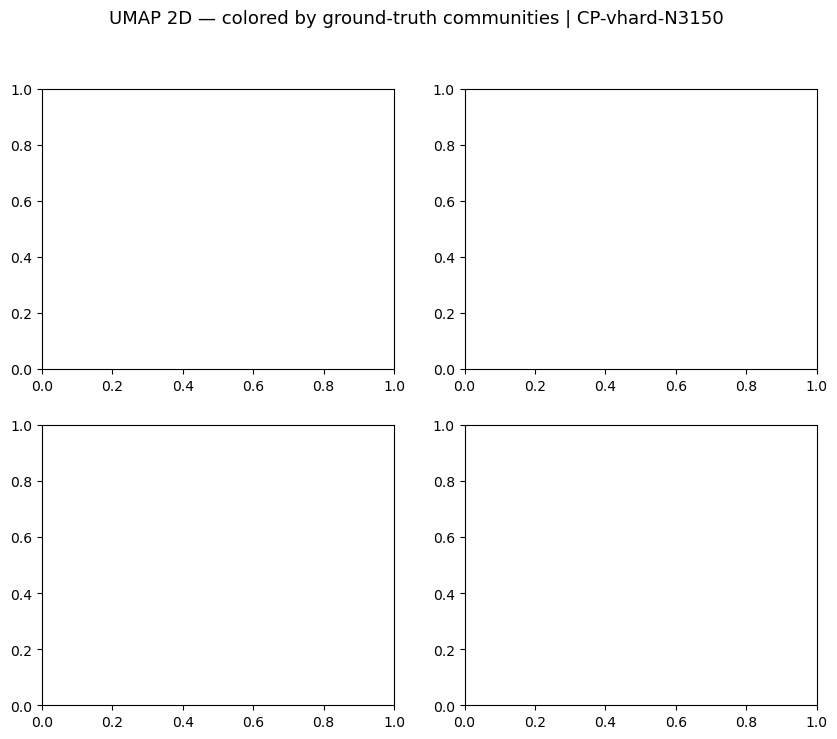

In [4]:
# =============== RUN ===============
# choose one difficulty
difficulty = "vhard"     # "easy" | "med" | "hard" | "vhard"
dim = 128
epochs = 1
seed_graph = 0
embed_seeds = [0]

# build big graph (you can switch to CP_PRESETS[difficulty] for smaller)
A, y = make_core_periphery_sparse(**CP_PRESETS_BIG["big-vhard"], seed=seed_graph)
print(A.shape, A.nnz, "labels:", np.bincount(y))

# train & save; pass device only (fair schedule can be toggled above)
train_and_save_for_graph(
    A, y, tag=f"CP-{difficulty}-N{A.shape[0]}",
    seeds=embed_seeds, dim=dim, epochs=epochs,
    euclid_overrides=dict(device=DEVICE),
    sphere_overrides=dict(device=DEVICE),
)

# visualize & report
tag = f"CP-{difficulty}-N{A.shape[0]}"
plot_umaps(tag, y, seed=embed_seeds[0])
df_rep = report_one(tag, seed=embed_seeds[0])
display(df_rep.style.format(precision=3))

# sanity: HIGH-D only (Raw vs Dir)
for name, _ in CONFIGS:
    U, V, ylab = load_run(tag, name, embed_seeds[0])
    m = metrics_highD(U, ylab, k=len(np.unique(ylab)), seed=embed_seeds[0])
    print(f"[{tag}] {name:10s} | ESim raw {m['ESim_raw']:.3f} dir {m['ESim_dir']:.3f} | "
          f"ARI raw {m['ARI_raw']:.3f} dir {m['ARI_dir']:.3f} | "
          f"AUC dot {p3_auc_dot_uv(U,V,ylab):.3f}")

# norm-shuffle effects on KMeans (HIGH-D) + norm histograms
_ = norm_shuffle_kmeans_effects(tag, seed=embed_seeds[0])
plot_norm_hist_by_label(tag, seed=embed_seeds[0])

In [5]:
# === Analysis battery: where does the info live (angles vs lengths)? ===
import os, numpy as np, scipy.sparse as sp, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import spearmanr


CONFIG_ORDER = ["Euclid-Dot", "Sphere-Dot"]  # keep this consistent with training

# Example: if you saved as emb_CP-med-N2100_{config}_seed0.npz
tag = "CP-vhard-N3150"   # <-- set to your dataset tag (filename middle part)
seed = 0

df = analyze_tag(tag, seed=seed, folds=5, midband=(0.2,0.6), A=A)
pd.set_option("display.max_columns", 200)
df

,tag,config,seed,T1_dir_acc,T1_dir_f1,T1_dpn_acc,T1_dpn_f1,T1_norm_acc,T1_norm_f1,T2_comm_acc,T2_comm_f1,T2_deg_R2,T2_logdeg_R2,T2_pr_R2,T3_auc,T3_auc_perm,T3_auc_drop,T3_auc_mid,T3_aucp_mid,T3_auc_drop_mid,T6_auc_orig,T6_auc_clamp,T6_auc_scr,T6_drop_clamp,T6_drop_scr,T8_p_deg,T8_s_deg,T8_p_logdeg,T8_s_logdeg,T9_ARI_raw,T9_AMI_raw,T9_ESim_raw,T9_ARI_dir,T9_AMI_dir,T9_ESim_dir
0,CP-vhard-N3150,Euclid-Dot,0,0.954286,0.954285,0.955556,0.955555,0.493016,0.491339,0.493016,0.491339,0.432978,0.435331,NaN,0.631644,0.611739,1.990482e-02,NaN,NaN,NaN,0.631644,0.657120,0.501197,-2.547625e-02,0.130448,-0.623956,-0.208501,-0.626184,-0.208501,0.868701,0.786052,0.867092,0.867517,0.784534,0.865364
1,CP-vhard-N3150,Sphere-Dot,0,0.965714,0.965711,0.964762,0.964758,0.489841,0.382114,0.489841,0.382114,0.000073,0.000074,NaN,0.660296,0.660296,-8.800122e-09,NaN,NaN,NaN,0.660296,0.660296,0.499061,-8.000111e-09,0.161235,-0.008558,-0.007207,-0.008625,-0.007207,0.000328,0.000236,0.000639,0.000360,0.000260,0.000659


,tag,config,seed,T1_dir_acc,T1_dir_f1,T1_dpn_acc,T1_dpn_f1,T1_norm_acc,T1_norm_f1,T2_comm_acc,T2_comm_f1,T2_deg_R2,T2_logdeg_R2,T2_pr_R2,T3_auc,T3_auc_perm,T3_auc_drop,T3_auc_mid,T3_aucp_mid,T3_auc_drop_mid,T6_auc_orig,T6_auc_clamp,T6_auc_scr,T6_drop_clamp,T6_drop_scr,T8_p_deg,T8_s_deg,T8_p_logdeg,T8_s_logdeg,T9_ARI_raw,T9_AMI_raw,T9_ESim_raw,T9_ARI_dir,T9_AMI_dir,T9_ESim_dir
0,CP-med-N2100,Euclid-Dot,0,0.983810,0.983809,0.983810,0.983809,0.494762,0.492945,0.494762,0.492945,0.024440,0.019705,NaN,0.885634,0.888332,-2.697452e-03,NaN,NaN,NaN,0.885634,0.994680,0.497011,-1.090462e-01,0.388623,-0.155354,0.112580,-0.139430,0.112580,0.934413,0.877676,0.933556,0.934413,0.877676,0.933556
1,CP-med-N2100,Sphere-Dot,0,0.981905,0.981904,0.983333,0.983333,0.484286,0.421811,0.484286,0.421811,0.001401,0.001323,NaN,0.913612,0.913612,-3.200036e-09,NaN,NaN,NaN,0.913612,0.913612,0.499911,-2.400027e-09,0.413701,-0.037424,-0.008107,-0.036371,-0.008107,0.919734,0.860192,0.900270,0.919734,0.860192,0.900270


In [ ]:
# Plot correation between degree and 

In [6]:
# --- NEW: angle vs norm ablations for logistic regression on U only ---

def make_variants_for_U(U, seed=0):
    """
    Returns four versions of U:
      - orig: original U
      - perm_norm: same directions, norms randomly permuted across nodes
      - scr_ang: angles scrambled (directions permuted), original norm per node kept
      - clamp: all vectors clamped to unit norm (remove norm info)
    """
    rng = np.random.RandomState(seed)
    Uh, r = to_unit_rows(U)

    # permute radii across nodes, keep each node's direction
    r_perm = r[rng.permutation(len(r))]
    U_perm_norm = Uh * r_perm[:, None]

    # scramble angles: use your helper (keeps each node's radius, shuffles directions)
    U_scr_ang = scramble_angles_keep_lengths(U, seed=seed+1)

    # clamp: remove norm information entirely
    U_clamp = clamp_unit_norm(U)

    return {
        "orig": U,
        "perm_norm": U_perm_norm,
        "scr_ang": U_scr_ang,
        "clamp": U_clamp,
    }

def logreg_probes_on_U(U, y, folds=5, seed=0, C=1.0, max_iter=2000):
    """
    Runs (Dir, Norm, Dir+Norm) probes on U:
      Dir uses unit directions \hat{U}
      Norm uses log(||U_i||)
      Dir+Norm concatenates both
    Returns a tidy DataFrame with acc, acc_std, f1, f1_std for each probe.
    """
    variants = make_variants_for_U(U, seed=seed)
    rows = []
    for name, Uv in variants.items():
        Uhat, r = to_unit_rows(Uv)
        X_dir  = Uhat
        X_norm = np.log(np.clip(r, 1e-12, None))[:, None]

        res_dir = _logreg_cv(X_dir,  y, folds=folds, seed=seed, C=C, max_iter=max_iter)
        res_nrm = _logreg_cv(X_norm, y, folds=folds, seed=seed, C=C, max_iter=max_iter)
        res_dn  = _logreg_cv(np.hstack([X_dir, X_norm]), y, folds=folds, seed=seed, C=C, max_iter=max_iter)

        rows.append(dict(variant=name, probe="Dir",      **res_dir))
        rows.append(dict(variant=name, probe="Norm",     **res_nrm))
        rows.append(dict(variant=name, probe="Dir+Norm", **res_dn))
    return pd.DataFrame(rows)

# --- Example usage for your trained runs ---
# For each config, load U and run the suite:
for cfg_name, _ in CONFIGS:
    U, V, y, _ = load_run(tag, cfg_name, embed_seeds[0], A=A)
    df_lr = logreg_probes_on_U(U, y, folds=5, seed=0, C=1.0, max_iter=2000)
    display(df_lr.sort_values(["probe","variant"]))


,variant,probe,acc,acc_std,f1,f1_std
9,clamp,Dir,0.954286,0.012754,0.954285,0.012754
0,orig,Dir,0.954286,0.012754,0.954285,0.012754
3,perm_norm,Dir,0.954286,0.012754,0.954285,0.012754
6,scr_ang,Dir,0.491746,0.011682,0.491505,0.011791
11,clamp,Dir+Norm,0.954286,0.012188,0.954284,0.012189
2,orig,Dir+Norm,0.955556,0.012579,0.955555,0.012579
5,perm_norm,Dir+Norm,0.955556,0.013506,0.955555,0.013506
8,scr_ang,Dir+Norm,0.494603,0.012361,0.494437,0.012382
10,clamp,Norm,0.521270,0.014638,0.505696,0.018069
1,orig,Norm,0.493016,0.013074,0.491339,0.013080


,variant,probe,acc,acc_std,f1,f1_std
9,clamp,Dir,0.965714,0.009712,0.965711,0.009711
0,orig,Dir,0.965714,0.009712,0.965711,0.009711
3,perm_norm,Dir,0.965714,0.009712,0.965711,0.009711
6,scr_ang,Dir,0.508254,0.014870,0.508049,0.014912
11,clamp,Dir+Norm,0.964127,0.008612,0.964123,0.008611
2,orig,Dir+Norm,0.964762,0.007606,0.964758,0.007604
5,perm_norm,Dir+Norm,0.964762,0.008363,0.964758,0.008361
8,scr_ang,Dir+Norm,0.506984,0.013416,0.506821,0.013465
10,clamp,Norm,0.498095,0.015435,0.375613,0.017353
1,orig,Norm,0.489841,0.013112,0.382114,0.019647


ERROR! Session/line number was not unique in database. History logging moved to new session 2


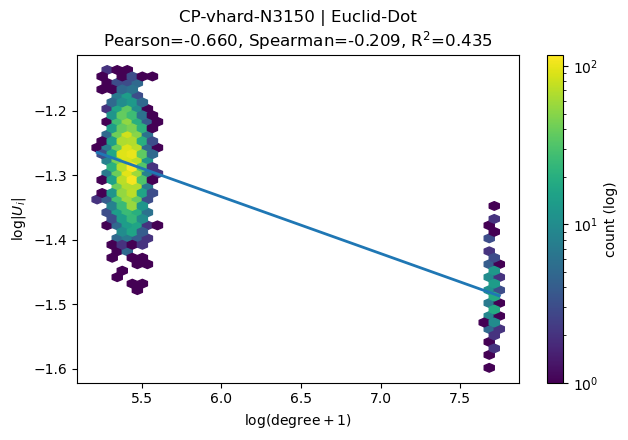

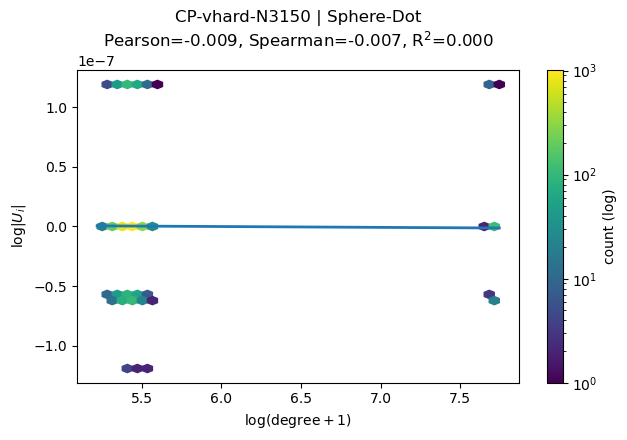

In [9]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr

def plot_degree_vs_norm(tag, cfg, seed=0):
    U, V, y, deg = load_run(tag, cfg, seed)
    if deg is None:
        raise ValueError("No degree vector found; re-run saving 'deg' or pass A into load_run to compute degrees.")

    # features
    r = np.linalg.norm(U, axis=1)
    x = np.log1p(deg).reshape(-1, 1)
    yv = np.log(np.clip(r, 1e-12, None))

    # correlations
    p = pearsonr(yv, x.ravel())[0]
    s = spearmanr(yv, x.ravel()).correlation

    # fit line
    lr = LinearRegression().fit(x, yv)
    xfit = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
    yfit = lr.predict(xfit)

    # plot (hexbin is nice for 3K+ points)
    plt.figure(figsize=(6.5, 4.5))
    hb = plt.hexbin(x.ravel(), yv, gridsize=40, bins='log')  # no explicit colors
    plt.plot(xfit.ravel(), yfit, linewidth=2)
    plt.xlabel(r"$\log(\mathrm{degree}+1)$")
    plt.ylabel(r"$\log |U_i|$")
    plt.title(f'{tag} | {cfg}\nPearson={p:.3f}, Spearman={s:.3f}, R$^2$={lr.score(x,yv):.3f}')
    cb = plt.colorbar()
    cb.set_label('count (log)')
    plt.tight_layout()
    plt.show()

# Example:
plot_degree_vs_norm(tag="CP-vhard-N3150", cfg="Euclid-Dot", seed=0)
plot_degree_vs_norm(tag="CP-vhard-N3150", cfg="Sphere-Dot", seed=0)


In [10]:
# How to scale up? 
# Use Block matrix to viz
